# Analyze Multiple Time Series 

This template provides a playbook to analyze multiple time series simultaneously. You will take an indepth look into your time series data by:

1. Loading and visualizing your data
2. Inspecting the distribution 
3. Analyzing subsets of your data
4. Decomposing time series into seasonality, trend and noise
5. Visualizing correlations with a clustermap 

In [1]:
# Load packages
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics import tsaplots
import statsmodels.api as sm
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import numpy as np
from scipy.signal import find_peaks
from scipy.signal import peak_prominences
import sklearn.metrics as sklm
import math
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.forecasting.stl import STLForecast
import sklearn.metrics as sklm
import math
import pmdarima as pm
from sklearn.model_selection import train_test_split
from scipy.stats.mstats import winsorize
from sktime.transformations.series.outlier_detection import HampelFilter
from sktime.datasets import load_airline
from statsmodels.tsa.seasonal import seasonal_decompose

## 1. Load and visualize your data


In [2]:
# Upload your data as CSV and load as a data frame
df = pd.read_csv(
    "training_data.csv",
    parse_dates=["times"],  # Tell pandas which column(s) to parse as dates
    index_col="times",  # Use a date column as your index
)
df.head()


,Series1,Series2,Series3,Series4,Series5,Series6,Series7,Series8,Series9,Series10,...,Series86,Series87,Series88,Series89,Series90,Series91,Series92,Series93,Series94,Series95
times,,,,,,,,,,,,,,,,,,,,,
1978-11-01,260.350122,265.379448,285.172883,266.774733,256.704939,259.962472,263.321555,262.017348,263.854085,272.871388,...,258.222624,274.719836,261.387957,254.903019,268.261197,267.028705,271.567729,266.947571,271.930426,271.223367
1978-11-02,259.943367,273.526405,266.913075,269.664513,265.024105,263.013930,263.091900,254.997818,273.320973,268.203996,...,260.759755,256.765620,261.998367,253.702352,259.935957,267.853531,271.902175,267.027663,273.179384,261.041906
1978-11-03,261.166744,280.097891,269.548552,262.272449,267.010886,252.386012,264.123102,259.100935,95.843387,275.385646,...,256.842154,254.905705,255.795448,255.256700,259.801775,267.847792,274.249467,265.555273,283.118344,265.802214
1978-11-04,262.674336,260.578072,264.910454,259.518157,256.495576,261.822173,257.527384,261.870500,270.146177,280.618387,...,261.104169,260.832802,253.945833,260.327452,260.210128,253.954682,275.750938,267.211299,267.702150,270.199622
1978-11-05,260.595601,259.042507,264.371437,259.113990,135.053552,263.016093,258.041649,259.521064,281.036349,281.804426,...,249.897195,261.487449,260.539897,265.635362,260.604379,271.746672,268.425619,213.152892,265.940686,268.912055


In [3]:
def plot_ts(the_df, start, stop):
    cols = the_df.columns[start:stop]
    ncols = len(cols)

    fig = make_subplots(rows=ncols, cols=1, shared_xaxes=True, shared_yaxes=True)

    for i, col in enumerate(cols, start=1):
        fig.add_trace(
            go.Scatter(x=the_df[col].index, y=the_df[col].values), row=i, col=1
        )

    fig.show()

(array([4.499e+03, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([1.60691795e+00, 2.48781346e+04, 4.97546623e+04, 7.46311900e+04,
        9.95077177e+04, 1.24384245e+05, 1.49260773e+05, 1.74137301e+05,
        1.99013828e+05, 2.23890356e+05, 2.48766884e+05]),
 <BarContainer object of 10 artists>)

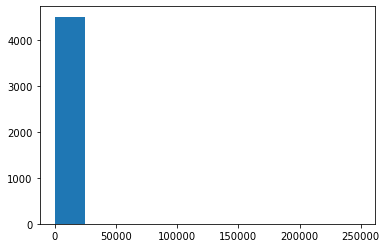

In [4]:
plt.hist(df["Series33"])

In [5]:
df.describe()

,Series1,Series2,Series3,Series4,Series5,Series6,Series7,Series8,Series9,Series10,...,Series86,Series87,Series88,Series89,Series90,Series91,Series92,Series93,Series94,Series95
count,4500.000000,4500.000000,4500.000000,4500.000000,4500.000000,4500.000000,4500.000000,4500.000000,4500.000000,4500.000000,...,4500.000000,4500.000000,4500.000000,4500.000000,4500.000000,4500.000000,4500.000000,4500.000000,4500.000000,4500.000000
mean,235.337807,235.185951,257.119299,239.654953,238.513402,237.394076,239.671876,240.898147,243.019340,246.655052,...,238.154101,238.044906,242.022069,241.938941,241.272843,247.095924,244.294038,247.168695,251.670045,250.847284
std,104.775007,28.136942,1432.794536,137.125243,69.951210,30.750001,85.086522,37.110095,54.097386,25.015245,...,73.426404,36.744796,194.876733,51.327813,32.450449,44.983278,29.069407,81.872944,151.634551,54.675068
min,48.651845,3.959538,12.122043,12.053992,21.673677,14.517858,4.129020,5.975818,2.311628,47.455347,...,42.121529,7.206873,0.624957,2.222981,16.129874,3.424011,20.131951,44.312590,14.322546,3.727069
25%,220.883472,222.803560,223.662381,224.497436,224.685951,225.073324,225.380081,226.222775,228.116083,234.101050,...,224.126738,225.677948,225.411633,227.415995,227.260922,233.880706,230.743172,232.831369,235.107396,236.734876
50%,232.031808,233.357038,234.716511,235.697719,236.002522,236.350220,237.156377,239.036286,240.880109,246.174667,...,235.632104,237.149773,237.629084,240.011160,240.230724,246.006118,243.278482,245.043923,247.842521,249.302872
75%,244.736482,246.307251,247.198465,247.700499,248.335740,248.528379,249.395015,252.241902,253.519363,257.830031,...,248.608277,249.642008,250.947732,254.034830,253.562213,257.934316,255.798960,257.561216,260.070280,261.568076
max,6245.296347,1127.317170,96312.789755,8113.844791,3138.791029,1414.721286,4885.972539,1331.238799,2304.190201,1013.433992,...,4078.676399,2016.329016,13135.124486,2674.126887,1124.772336,2738.885407,1277.634633,5464.333951,9684.864349,3222.739141


### Forecast

In [6]:
test_df = df.iloc[-2:]
test_df

,Series1,Series2,Series3,Series4,Series5,Series6,Series7,Series8,Series9,Series10,...,Series86,Series87,Series88,Series89,Series90,Series91,Series92,Series93,Series94,Series95
times,,,,,,,,,,,,,,,,,,,,,
1991-02-24,219.132561,206.841366,199.059285,206.121832,201.198456,204.610866,204.012294,205.220545,227.599887,230.456250,...,208.282917,212.440231,207.281696,218.14059,211.272423,218.245163,209.340164,224.903791,221.363627,221.621945
1991-02-25,221.906904,209.384404,212.940469,210.951168,200.843305,215.455393,203.517218,214.127919,226.265642,225.027412,...,213.984178,209.193550,206.859867,216.48676,213.265123,221.629532,217.607350,227.577026,211.220300,224.895289


In [7]:
forecast_df = pd.DataFrame(df.iloc[-3]).T
forecast_df.index = forecast_df.index + pd.to_timedelta(1, unit='D')
forecast_df = pd.concat([forecast_df, pd.DataFrame(df.iloc[-3]).T])
forecast_df.index = forecast_df.index + pd.to_timedelta(1, unit='D')
forecast_df = forecast_df.sort_index()
forecast_df

,Series1,Series2,Series3,Series4,Series5,Series6,Series7,Series8,Series9,Series10,...,Series86,Series87,Series88,Series89,Series90,Series91,Series92,Series93,Series94,Series95
1991-02-24,215.427709,199.588083,214.029922,205.713226,210.227246,198.116584,209.574694,208.353874,215.006025,229.279419,...,208.8965,202.651041,211.27579,202.449621,213.470966,228.272449,211.304414,222.775122,219.844359,230.049277
1991-02-25,215.427709,199.588083,214.029922,205.713226,210.227246,198.116584,209.574694,208.353874,215.006025,229.279419,...,208.8965,202.651041,211.27579,202.449621,213.470966,228.272449,211.304414,222.775122,219.844359,230.049277


In [8]:
forecast_df.to_csv("forecasts_repeatlast.csv")

In [9]:
mape = sklm.mean_absolute_percentage_error(test_df, forecast_df)
print(f'Mean Absolute Percentage Error: {mape:.2f}%')



rms = math.sqrt(sklm.mean_squared_error(test_df, forecast_df))
print(f'Root Mean Squared Error: {rms:.2f}%')


Mean Absolute Percentage Error: 0.07%
Root Mean Squared Error: 40.08%
